In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [3]:
df = pd.read_csv("ecommerce_customer_data_custom_ratios.csv")
df.head()

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,46251,2020-09-08 09:38:32,Electronics,12,3,740,Credit Card,37,0.0,Christine Hernandez,37,Male,0
1,46251,2022-03-05 12:56:35,Home,468,4,2739,PayPal,37,0.0,Christine Hernandez,37,Male,0
2,46251,2022-05-23 18:18:01,Home,288,2,3196,PayPal,37,0.0,Christine Hernandez,37,Male,0
3,46251,2020-11-12 13:13:29,Clothing,196,1,3509,PayPal,37,0.0,Christine Hernandez,37,Male,0
4,13593,2020-11-27 17:55:11,Home,449,1,3452,Credit Card,49,0.0,James Grant,49,Female,1


In [4]:
#Data Cleaning
df.isnull().sum()
df.drop_duplicates(inplace=True)
if 'InvoiceDate' in df.columns:
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    
 

In [5]:
#3. Feature Engineering (RFM Analysis)
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'])
import datetime as dt

snapshot_date = df['Purchase Date'].max() + dt.timedelta(days=1)

rfm = df.groupby('Customer ID').agg(
    Recency=('Purchase Date', lambda x: (snapshot_date - x.max()).days),
    Frequency=('Purchase Date', 'count'),
    Monetary=('Total Purchase Amount', 'sum')
)

rfm.head()
                           


,Recency,Frequency,Monetary
Customer ID,,,
1,58,1,3491
2,299,3,7988
3,89,8,22587
4,127,4,8715
5,171,8,12524


In [8]:
#4. RFM Scoring & Customer Segmentation (K-Means)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'], 4, labels=[1, 2, 3, 4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])
rfm['RFM_Score'] = (
    rfm['R_Score'].astype(str) +
    rfm['F_Score'].astype(str) +
    rfm['M_Score'].astype(str)
)

rfm.head()



,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
Customer ID,,,,,,,
1,58,1,3491,4,1,1,411
2,299,3,7988,2,1,1,211
3,89,8,22587,3,4,4,344
4,127,4,8715,3,2,1,321
5,171,8,12524,3,4,2,342


In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(
    rfm[['Recency', 'Frequency', 'Monetary']]
)


kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()


,Recency,Frequency,Monetary
Cluster,,,
0,136.843843,8.440577,24494.153654
1,183.652246,5.715804,15614.061368
2,194.014351,3.332216,8292.908731
3,719.847954,2.939600,7825.245392


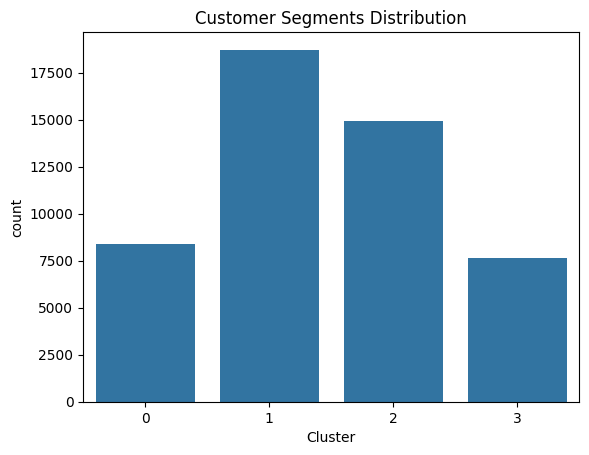

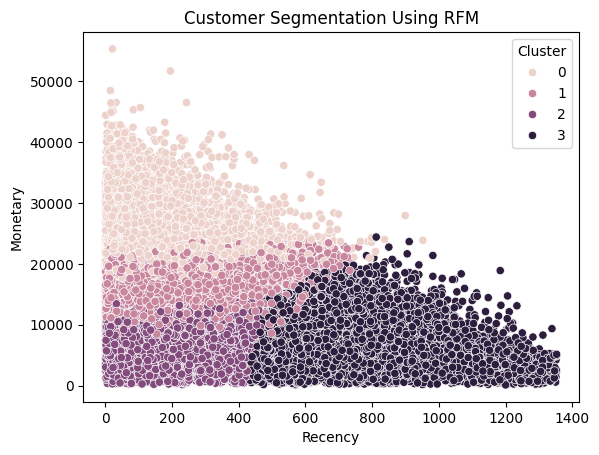

In [ ]:
# cluster visualization 

sns.countplot(x='Cluster', data=rfm)
plt.title("Customer Segments Distribution")
plt.show()
sns.scatterplot(
    x='Recency',
    y='Monetary',
    hue='Cluster',
    data=rfm
)
plt.title("Customer Segmentation Using RFM")
plt.show()


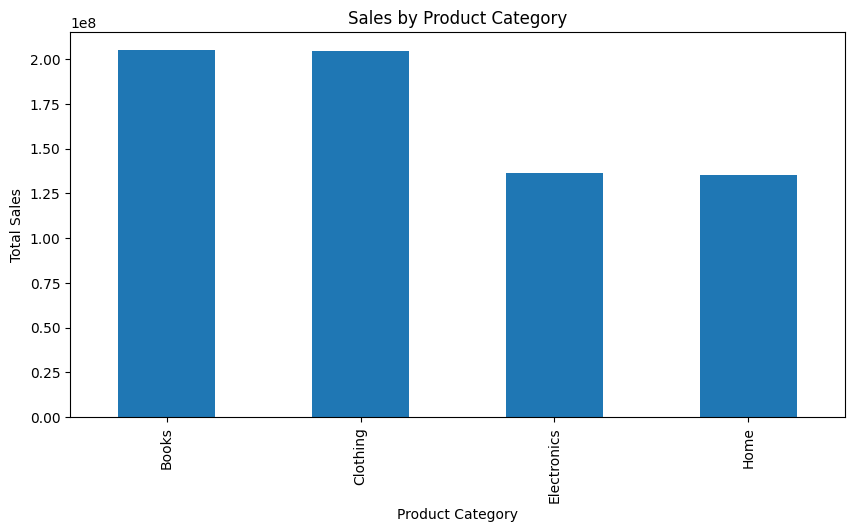

In [ ]:
#5. Purchase Pattern & Retention Analysis
#Purchases by Product Category
category_sales = df.groupby('Product Category')['Total Purchase Amount'].sum().sort_values(ascending=False)

category_sales
category_sales.plot(kind='bar', figsize=(10,5), title="Sales by Product Category")
plt.ylabel("Total Sales")
plt.show()


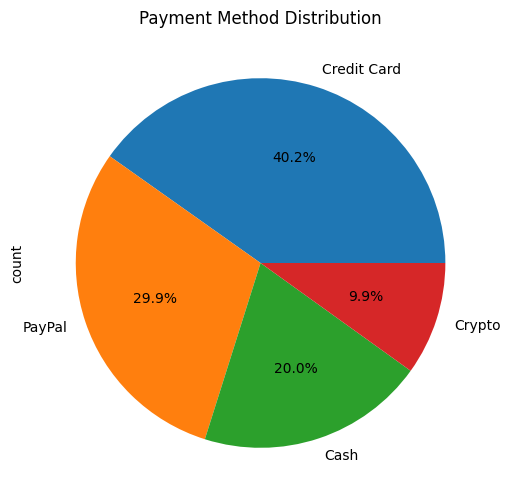

In [15]:
#Purchase Pattern by Payment Method
payment_pattern = df['Payment Method'].value_counts()

payment_pattern

payment_pattern.plot(kind='pie', autopct='%1.1f%%', figsize=(6,6))
plt.title("Payment Method Distribution")
plt.show()


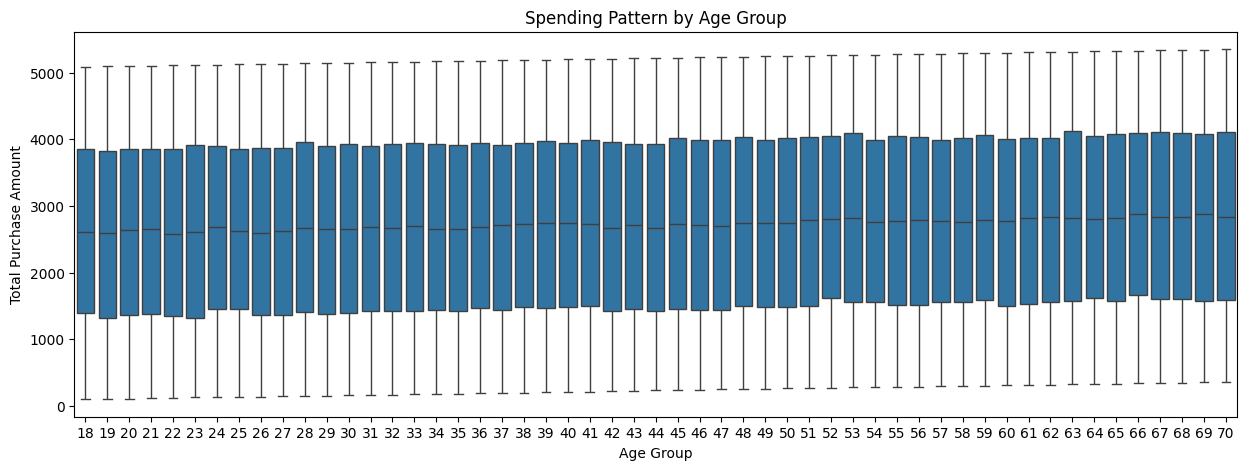

In [ ]:
#Spending Pattern by Customer Age
df['Age_Group'] = pd.cut(
    df['Age'],
    bins=[18, 25, 35, 45, 55, 65, 100],
    labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
)
plt.figure(figsize=(15,5))
sns.boxplot(x='Age', y='Total Purchase Amount', data=df)
plt.title("Spending Pattern by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Total Purchase Amount")
plt.show()

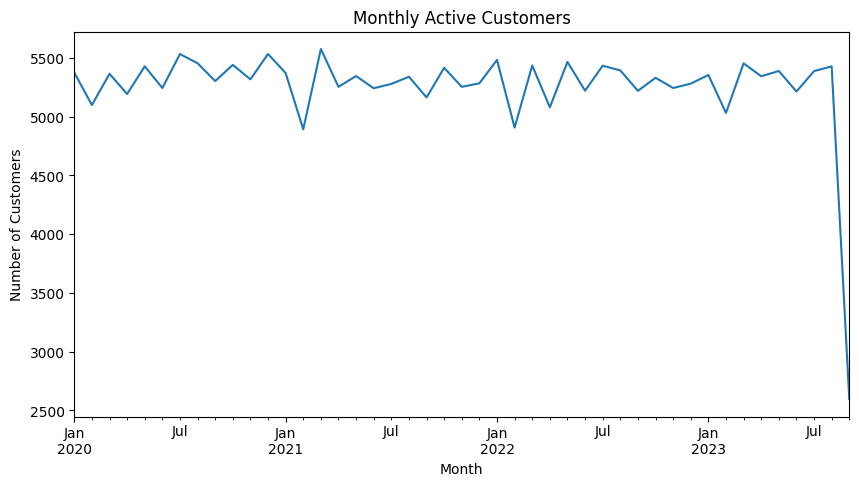

In [22]:
#Monthly Active Customers (Retention Trend)
df['Month'] = df ['Purchase Date'].dt.to_period('M')
monthly_customers = df.groupby('Month')['Customer ID'].nunique()
 
monthly_customers.plot(figsize=(10,5))
plt.title("Monthly Active Customers")
plt.ylabel("Number of Customers")
plt.xlabel("Month")
plt.show()

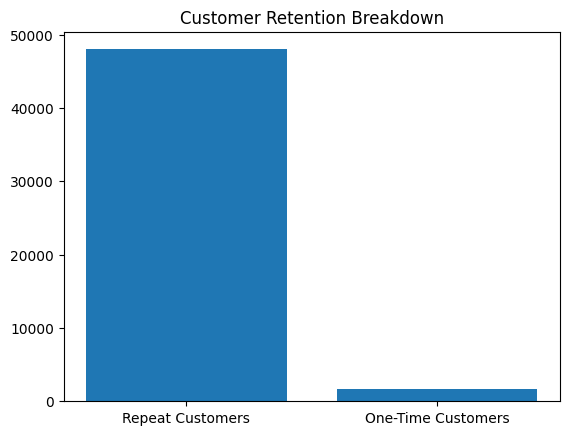

In [25]:
#Repeat vs One-Time Customers
purchase_counts = df.groupby('Customer ID').size()
repeat_customers = (purchase_counts > 1).sum()
one_time_customers = (purchase_counts == 1).sum()

repeat_customers, one_time_customers
plt.bar(['Repeat Customers', 'One-Time Customers'],
        [repeat_customers, one_time_customers])
plt.title("Customer Retention Breakdown")
plt.show()

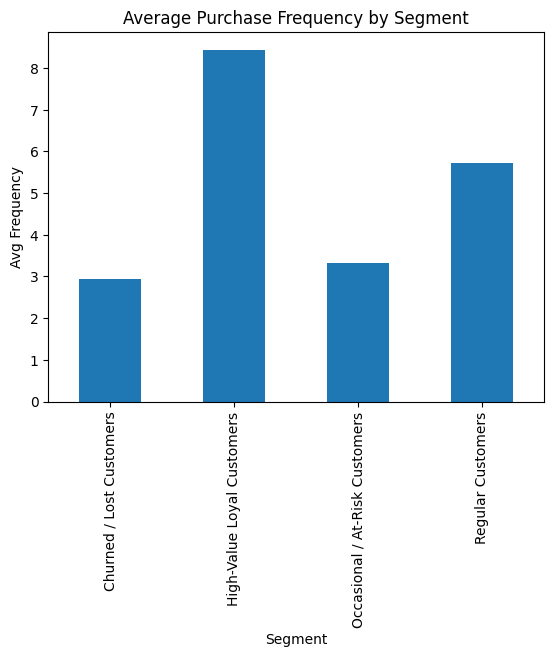

In [ ]:
#RETENTION BY CUSTOMER SEGMENT
cluster_labels = {
    0: "High-Value Loyal Customers",
    1: "Regular Customers",
    2: "Occasional / At-Risk Customers",
    3: "Churned / Lost Customers"
}

rfm['Segment'] = rfm['Cluster'].map(cluster_labels)

segment_retention = rfm.groupby('Segment')['Frequency'].mean()
segment_retention
segment_retention.plot(kind='bar', title="Average Purchase Frequency by Segment")
plt.ylabel("Avg Frequency")
plt.show()



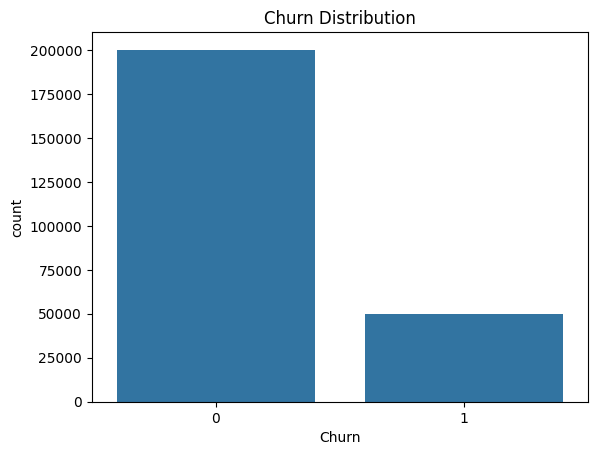

In [ ]:
#6. Churn Risk Analysis
#Churn Distribution
df['Churn'].value_counts()

sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()
#Churn = 1 → Customer left
#Churn = 0 → Customer retained



In [30]:
#Merge RFM Segment with Original Data
df_churn = df.merge(
    rfm[['Segment']],
    left_on='Customer ID',
    right_index=True,
    how='left'
)

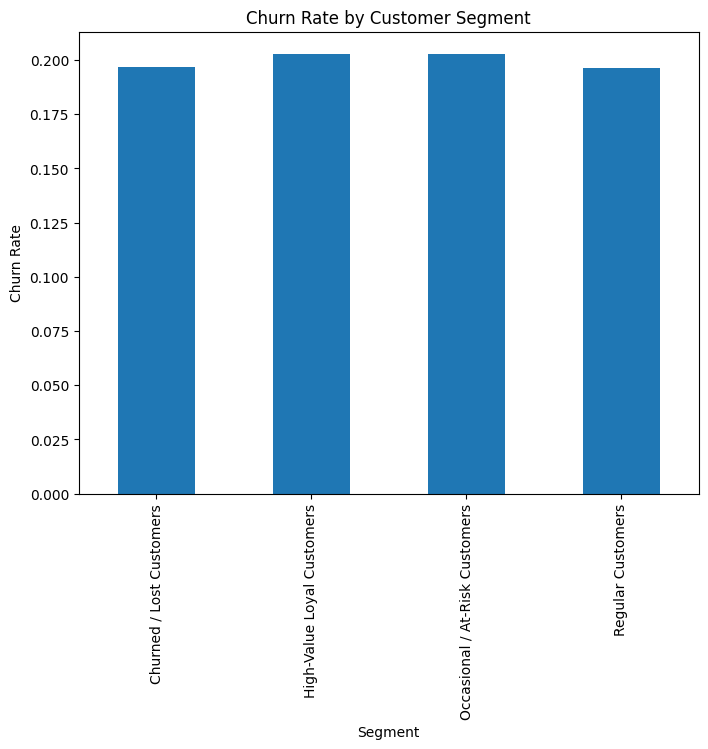

In [33]:
#Churn Rate by Segment
churn_by_segment = df_churn.groupby('Segment')['Churn'].mean()
churn_by_segment

churn_by_segment.plot(
    kind='bar',
    figsize=(8,6),
    title="Churn Rate by Customer Segment"
)
plt.ylabel("Churn Rate")
plt.show()


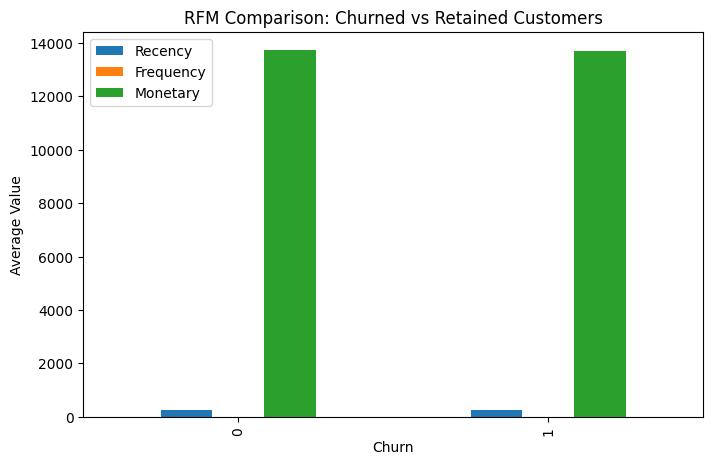

In [38]:
#Compare RFM for Churned vs Retained Customers
rfm_churn = rfm.merge(
    df[['Customer ID', 'Churn']].drop_duplicates(),
    left_index=True,
    right_on='Customer ID',
    how='left'
)
rfm_churn.groupby('Churn')[['Recency', 'Frequency', 'Monetary']].mean()

rfm_churn.groupby('Churn')[['Recency', 'Frequency', 'Monetary']].mean().plot(
    kind='bar',
    figsize=(8,5),
    title="RFM Comparison: Churned vs Retained Customers"
)
plt.ylabel("Average Value")
plt.show()
